# Comparing Three-level GLM Results from FSL GUI and Nipype (Docker)

<mark>**Execute this notebook outside of the docker container**</mark>

In this notebook we explore the outputs of a basic fMRI `Three Level GLM` pipeline in FSL and Nipype. Specifically, we do a quality control check to ensure that results produced by FSL via the Graphical User Interface (GUI) and an FSL worklow in `nipype` produce the same results. Since FSL overwrites outputs and only produces the final results, we used the corresponding `bash` commands to generate stepwise outputs.

Importantly, we carry out all analyses in `20.04.2 LTS (Focal Fossa)` as we (and [others](https://www.frontiersin.org/articles/10.3389/fninf.2015.00012/full)) have found that FSL uses mathematical functions based on single-precision floating-point arithmetic whose implementations differ across operating systems. Hence, you cannot expect that your FSL results obtained in a MAC, Windows, or other Linux (e.g., neurodebian) OS will match the results/values that we report here. 

In the following, we use an fMRI dataset that used the Flanker task, which can be downloaded [here](https://openneuro.org/datasets/ds000102/versions/00001). We choose `run-1` of `subject-11` and run the preprocess (1) in FSL GUI (6.0.4), with (2) nipype and (3) FSL (6.0.4) command in the docker. Then we compare results from these three methods step by step.

<mark>**Note:**</mark> When run FSL GUI, some output files will be overwritten. Therefore, we use FSL command (outside of the docker, the same system environment as FSL GUI) as an alternative so that we can get the output file and do the comparison at each step. To make sure that FSL command is a good alternative of FSL GUI, we compared the final output of them and found no differences.

In [1]:
%matplotlib inline
import numpy as np
from nltools.data import Brain_Data
from nilearn.image import get_data, load_img, mean_img
from nilearn.plotting import plot_epi
import matplotlib.pyplot as plt

/usr/local/miniconda3/envs/naturalistic/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


## Preprocessing

This preprocessing is conducted within the first-level GLM process. All the comparisons for this part are on `sub-11`.

###  Step 1: Compare the result of img2float

img2float is the first step in fsl

In our **nipype** notebook, this corresponds to the node `img2float`

In **fsl**, you can use terminal open a folder and use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths /home/.../flanker/sub-11/func/sub-11_task-flanker_run-1_bold prefiltered_func_data -odt float
```

then it will generate a file called `prefiltered_func_data.nii.gz`

In [2]:
# img2float result from fsl gui
file_fsl_gui = '../file4comparison/step_1_gui_prefiltered_func_data.nii.gz'

# img2float result from nipype
file_fsl_nipype = '../file4comparison/step_1_nipype_bold_dtype.nii.gz'

In [3]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(146, 238955)
(146, 238955)


In [4]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 34887430 voxels are different


###  Step 2: Compare the result of extractref

extract the middle volume as the reference is the second step in fsl


In our **nipype** notebook, this corresponds to the node `extractref`

In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslroi prefiltered_func_data example_func 73 1
```

then it will generate a file called `example_func.nii.gz`

In [5]:
# extractref result from fsl gui
file_fsl_gui = '../file4comparison/step_2_gui_example_func.nii.gz'

# extractref result from nipype
file_fsl_nipype = '../file4comparison/step_2_nipype_bold_dtype_roi.nii.gz'

In [6]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [7]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


###  Step 3: Compare the result motion correction

Realign the functional runs to the middle volume of each run

In our **nipype** notebook, this corresponds to the node `realign`

In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/mcflirt -in prefiltered_func_data -out prefiltered_func_data_mcf -mats -plots -reffile example_func -rmsrel -rmsabs -spline_final
```

In **fsl GUI**, it corresponds to

![image](https://user-images.githubusercontent.com/20402800/125661408-9d6ed3a2-2537-44dd-879f-85181424b171.png)

then it will generate a file called `prefiltered_func_data_mcf.nii.gz`

In [8]:
# realign result from fsl gui
file_fsl_gui = '../file4comparison/step_3_gui_prefiltered_func_data_mcf.nii.gz'

# realign result from nipype
file_fsl_nipype = '../file4comparison/step_3_nipype_bold_dtype_mcf.nii.gz'

In [9]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(146, 238955)
(146, 238955)


In [10]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 34887430 voxels are different


###  Step 4: Compare the result of meanfunc

Extract the mean volume of the functional run

In our **nipype** notebook, this corresponds to the node `meanfunc`,

<mark> Later, FSL applied other transformations on this meanfunc file without renaming, so if executing this step afterwards, results might be different. 
    Thus, we did not provide files for this step.</mark>


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_mcf -Tmean mean_func
```

then it will generate a file called `mask.nii.gz`

In [11]:
# meanfunc result from fsl gui
file_fsl_gui = '../file4comparison/step_4_gui_mean_func.nii.gz'

# meanfunc result from nipype
file_fsl_nipype = '../file4comparison/step_4_nipype_bold_dtype_mcf_mean.nii.gz'

In [12]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [13]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


###  Step 5: Compare the result of meanfuncmask

Strip the skull from the mean functional to generate a mask

In our **nipype** notebook, this corresponds to the node `meanfuncmask`,


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/bet2 mean_func mask -f 0.3 -n -m; /usr/local/fsl/bin/immv mask_mask mask
```

then it will generate a file called `mask.nii.gz`

<mark>
    Later, FSL applied other transformations on this mask file without renaming, so if executing this step afterwards, results might be different. 
    Thus, we did not provide files for this step.
</mark>

In [14]:
# meanfuncmask result from fsl gui
file_fsl_gui = '../file4comparison/step_5_gui_mask.nii.gz'

# meanfuncmask result from nipype
file_fsl_nipype = '../file4comparison/step_5_nipype_bold_dtype_mcf_mean_brain_mask.nii.gz'

In [15]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

/usr/local/miniconda3/envs/naturalistic/lib/python3.7/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/miniconda3/envs/naturalistic/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


(238955,)


/usr/local/miniconda3/envs/naturalistic/lib/python3.7/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int16 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/usr/local/miniconda3/envs/naturalistic/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


(238955,)


In [16]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


###  Step 6: Compare the result of maskfunc

Mask the functional runs with the extracted mask

In our **nipype** notebook, this corresponds to the node `maskfunc`,


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_mcf -mas mask prefiltered_func_data_bet
```

In **fsl GUI**, it corresponds to 

![image](https://user-images.githubusercontent.com/20402800/125662332-488fddef-1950-48b5-af4d-6f3befffd24e.png)

then it will generate a file called `prefiltered_func_data_bet.nii.gz`

In [17]:
# maskfunc result from fsl gui
file_fsl_gui = '../file4comparison/step_6_gui_prefiltered_func_data_bet.nii.gz'

# maskfunc result from nipype
file_fsl_nipype = '../file4comparison/step_6_nipype_bold_dtype_mcf_bet.nii.gz'

In [18]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(146, 238955)
(146, 238955)


In [19]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 34887430 voxels are different


###  Step 7: Compare the result of thresholding

7.1: Determine the 2nd and 98th percentile intensities of each functional run. It will return two numbers, which will be used in the following step.

7.2: Threshold the first run of the functional data at 10% of the 98th percentile

In our **nipype** notebook, this corresponds to the node `getthreshold` & `threshold`,


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslstats prefiltered_func_data_bet -p 2 -p 98
0.000000 873.492249 (these numbers are for subject-11 run-01)
/usr/local/fsl/bin/fslmaths prefiltered_func_data_bet -thr 87.3492249 -Tmin -bin mask -odt char
```

All steps perform on `mask.nii.gz`

<mark>
    Later, FSL applied other transformations on this mask file without renaming, so if executing this step afterwards, results might be different. 
    Thus, we did not provide files for this step.
</mark>

###  Step 8: Compare the result of dilate the mask

Use the threshold from **Step 7** to dilate the mask

In our **nipype** notebook, this corresponds to the node `dilatemask`,


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths mask -dilF mask
```

All steps perform on `mask.nii.gz`

In [20]:
# dilatemask result from fsl gui
file_fsl_gui = '../file4comparison/step_8_gui_mask.nii.gz'

# dilatemask result from nipype
file_fsl_nipype = '../file4comparison/step_8_nipype_bold_dtype_mcf_bet_thresh_dil.nii.gz'

In [21]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

/usr/local/miniconda3/envs/naturalistic/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


(238955,)


/usr/local/miniconda3/envs/naturalistic/lib/python3.7/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "


(238955,)


In [22]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


###  Step 9: Compare the result of maskfunc2

Mask the motion corrected functional runs with the dilated mask

In our **nipype** notebook, this corresponds to the node `maskfunc2`,


In **fsl**, you can use the command from your fsl logfile, for example:

```
/opt/fsl-6.0.4/bin/fslmaths prefiltered_func_data_mcf -mas mask prefiltered_func_data_thresh
```

Output file: `prefiltered_func_data_thresh.nii.gz`

In [23]:
# maskfunc2 result from fsl gui
file_fsl_gui = '../file4comparison/step_9_gui_prefiltered_func_data_thresh.nii.gz'

# maskfunc2 result from nipype
file_fsl_nipype = '../file4comparison/step_9_nipype_bold_dtype_mcf_thresh.nii.gz'

In [24]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(146, 238955)
(146, 238955)


In [25]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 34887430 voxels are different


###  Step 10: Compare the result of SUSAN Noise Reduction

10.1: Determine the mean image from each TR

10.2: Determine the median value of the TRs using the mask

10.3: Merge the median values with the mean functional images into a coupled list. The output of this merge node will go into susan as usans

10.4: Smooth each run using SUSAN with the brightness threshold set to 75% of the median value for each run and a mask constituting the mean functional


Mask the motion corrected functional runs with the dilated mask

In our **nipype** notebook, this corresponds to the node `meanfunc2`, `medianval`, `mergenode`, & `smooth`


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_thresh -Tmean mean_func

/usr/local/fsl/bin/fslstats prefiltered_func_data_mcf -k mask -p 50
728.800232 (this number is for subject-11 run-01)

/usr/local/fsl/bin/susan prefiltered_func_data_thresh 546.600174 2.12314225053 3 1 1 mean_func 546.600174 prefiltered_func_data_smooth

```
In **fsl GUI**, it corresponds to 

![image](https://user-images.githubusercontent.com/20402800/125663421-302ddfb6-9438-4e8d-aa7a-48200416722f.png)


Output file: `prefiltered_func_data_smooth.nii.gz`

<mark>
    Later, FSL applied other transformations on this smoothed file without renaming, so if executing this step afterwards, results might be different. 
    Thus, we did not provide files for this step.
</mark>

###  Step 11: Compare the result of maskfunc3

Mask the smoothed data with the dilated mask

In our **nipype** notebook, this corresponds to the node `maskfunc3`


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_smooth -mas mask prefiltered_func_data_smooth

```

This step performs on `prefiltered_func_data_smooth.nii.gz`

####  Version A: FWHM = 4.9996179300001655 in Nipype

In the FSL GUI where SUSAN noise reduction is specified, a brightness threshold (bt) is needed and estimated from a FWHM smoothing kernel. Surprisingly, even a slight difference in bt can lead to very different results in the final stage of the GLM analysis. We used FWHM as 5 mm in FSL and obtained a bt of 2.12314225053. Yet, Nipype uses a different algorithm (bt = float(fwhm) / np.sqrt(8 * np.log(2))) to calculate bt from FSL. Therefore, to acquire the same bt, FWHM should be set as **4.9996179300001655** in Nipype rather than 5.

Output file: 
- `prefiltered_func_data_smooth.nii.gz` in FSL
- `...smooth_maths.nii.gz` in Nipype


In [26]:
# thresholding result from fsl gui
file_fsl_gui = '../file4comparison/step_11_gui_prefiltered_func_data_smooth.nii.gz'

# thresholding result from nipype
file_fsl_nipype = '../file4comparison/step_11_nipype_A_bold_dtype_mcf_thresh_smooth_maths.nii.gz'

In [27]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(146, 238955)
(146, 238955)


In [28]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 34887430 voxels are different


####  Version B: FWHM = 5 in Nipype

Here we set FWHM = 5 in both Nipype and FSL to demonstrate how different the results will be

In [29]:
# smooth result from fsl gui
file_fsl_gui = '../file4comparison/step_11_gui_prefiltered_func_data_smooth.nii.gz'

# smooth result from nipype
file_fsl_nipype = '../file4comparison/step_11_nipype_B_bold_dtype_mcf_thresh_smooth_maths.nii.gz'

In [30]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(146, 238955)
(146, 238955)


In [31]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

27981621 out of 34887430 voxels are different


###  Step 12: Compare the result of intnorm

Scale each volume of the run so that the median value of the run is set to 10000


In our **nipype** notebook, this corresponds to the node `intnorm`


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_smooth -mul 13.7211811425 prefiltered_func_data_intnorm 
(this number is for subject-11 run-01)

```

Output file: `prefiltered_func_data_intnorm.nii.gz`

In [32]:
# intnorm result from fsl gui
file_fsl_gui = '../file4comparison/step_12_gui_prefiltered_func_data_intnorm.nii.gz'

# intnorm result from nipype
file_fsl_nipype = '../file4comparison/step_12_nipype_bold_dtype_mcf_thresh_smooth_maths_intnorm.nii.gz'

In [33]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(146, 238955)
(146, 238955)


In [34]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 34887430 voxels are different


###  Step 13: Compare the result of Temporal Filtering (last step of preproc)

13.1: Generate a mean functional image from the scaled data

13.2: Perform temporal highpass filtering on the data

13.3: Rename `prefiltered_func_data_tempfilt.nii.gz` as `filtered_func_data.nii.gz`


In our **nipype** notebook, this corresponds to the node `intnorm`


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths prefiltered_func_data_intnorm -Tmean tempMean
/usr/local/fsl/bin/fslmaths prefiltered_func_data_intnorm -bptf 25.0 -1 -add tempMean prefiltered_func_data_tempfilt
/usr/local/fsl/bin/fslmaths prefiltered_func_data_tempfilt filtered_func_data

```

In **fsl GUI**, it corresponds to

![image](https://user-images.githubusercontent.com/20402800/125667188-68e8000e-307b-42e9-804a-c4b6dffa36a5.png)

Output file: `filtered_func_data.nii.gz` (**This is our final preoprocessed bold data**)

#### 13.1: Generate a mean functional image from the scaled data

Output file: `tempMean.nii.gz`

<mark>
    We did not provide files for this step since this file will be removed at the end of the preprocessing.
</mark>

#### 13.2 & 13.3: Perform temporal highpass filtering on the data & Rename


Output file: `prefiltered_func_data_tempfilt.nii.gz`

In [35]:
# thresholding result from fsl gui
file_fsl_gui = '../file4comparison/step_13_gui_filtered_func_data.nii.gz'

# thresholding result from nipype
file_fsl_nipype = '../file4comparison/step_13_nipype_bold_dtype_mcf_thresh_smooth_maths_intnorm_tempfilt.nii.gz'

In [36]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(146, 238955)
(146, 238955)


In [37]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 34887430 voxels are different


###  Step 14: Compare the result of meanfunc4

Generate a mean functional image from the functional run (**This will be used in glm**)


In our **nipype** notebook, this corresponds to the node `meanfunc4`


In **fsl**, you can use the command from your fsl logfile, for example:

```
/usr/local/fsl/bin/fslmaths filtered_func_data -Tmean mean_func

```

Output file: `mean_func.nii.gz`

In [38]:
# meanfunc4 result from fsl gui
file_fsl_gui = '../file4comparison/step_14_gui_mean_func.nii.gz'

# meanfunc4 result from nipype
file_fsl_nipype = '../file4comparison/step_14_nipype_bold_dtype_mcf_thresh_smooth_maths_intnorm_tempfilt_mean.nii.gz'

In [39]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [40]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


## First-level GLM

###  Step 15: Compare the result of the First-level GLM

#### Vesion A

In this version, all parameters are set up correctly.

In [41]:
# cope result from fsl gui
file_fsl_gui = '../file4comparison/step_15_gui_cope1.nii.gz'

# cope result from nipype
file_fsl_nipype = '../file4comparison/step_15_nipype_A_cope1.nii.gz'

In [42]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [43]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


#### Version B

In this version, we compare the first-level result when FWHM = 5 in both Nipype and FSL (see Step 11 for more information)

In [44]:
# cope result from fsl gui
file_fsl_gui = '../file4comparison/step_15_gui_cope1.nii.gz'

# cope result from nipype
file_fsl_nipype = '../file4comparison/step_15_nipype_B_cope1.nii.gz'

In [45]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [46]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

223069 out of 238955 voxels are different


Text(0, 0.5, 'Difference')

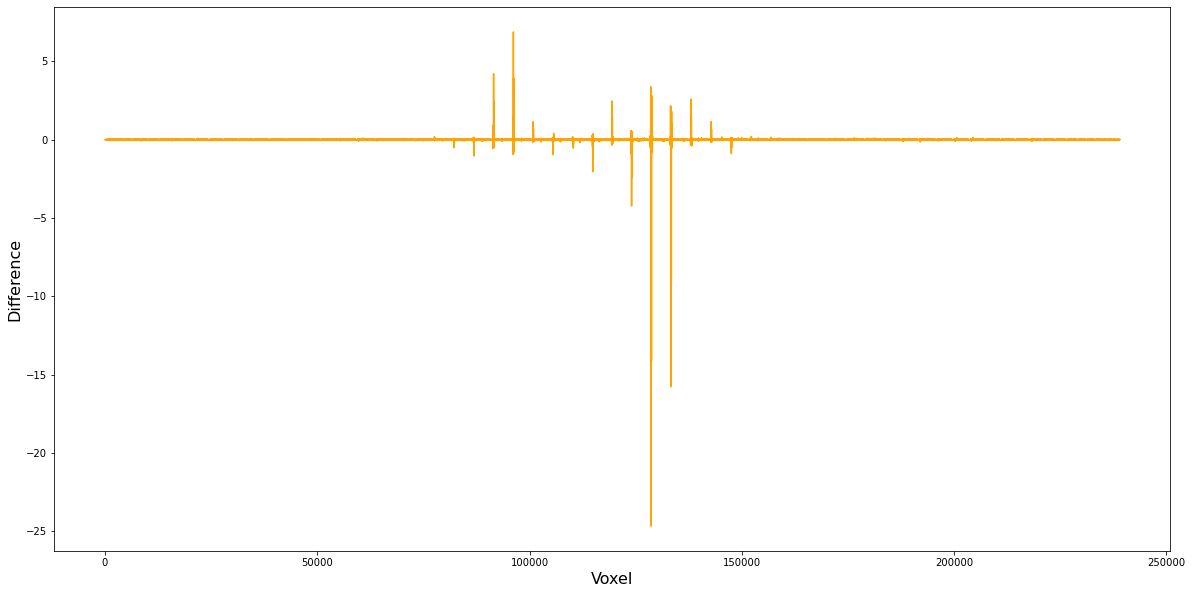

In [47]:
plt.figure(figsize=(20,10))
plt.plot(diff, linestyle='-', color='orange')
plt.xlabel("Voxel", fontsize=16)
plt.ylabel("Difference", fontsize=16)
# plt.savefig("../figures/comparison_FWHM_5.jpeg",dpi=600)

## Second-level GLM

This part, we compare results of `sub-02` from FSL GUI and Nipype

### Step 16: Compare the result of Registration

Before the second-level GLM, we need to register outputs from the first level into a standardized space.

In [48]:
# standardized cope result from fsl gui
file_fsl_gui = '../file4comparison/step_16_gui_cope1.nii.gz'

# standardized cope result from nipype
file_fsl_nipype = '../file4comparison/step_16_nipype_cope1_flirt.nii.gz'

In [49]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [50]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


#### 16.2 compare example_func2highres & highres2standard

`example_func2highres.mat` & `highres2example_func.mat`

4X4 matrices, eyeball they are the same.

**Corresponding FSL command:**

```
/usr/local/fsl/bin/flirt -in example_func -ref highres -out example_func2highres -omat example_func2highres.mat -cost corratio -dof 12 -searchrx -180 180 -searchry -180 180 -searchrz -180 180 -interp trilinear 

/usr/local/fsl/bin/convert_xfm -inverse -omat highres2example_func.mat example_func2highres.mat
```

`standard2highres.mat` & `highres2standard.mat`

4X4 matrices, eyeball they are the same.

**Corresponding FSL command:**

```
/usr/local/fsl/bin/flirt -in highres -ref standard -out highres2standard -omat highres2standard.mat -cost corratio -dof 12 -searchrx -180 180 -searchry -180 180 -searchrz -180 180 -interp trilinear 

/usr/local/fsl/bin/convert_xfm -inverse -omat standard2highres.mat highres2standard.mat
```

### Step 17: Compare the result of the Second-level GLM

In [51]:
# res4d result from fsl gui
file_fsl_gui = '../file4comparison/step_17_gui_cope1.nii.gz'

# meanfunc4 result from nipype
file_fsl_nipype = '../file4comparison/step_17_nipype_cope1.nii.gz'

In [52]:
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [53]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


##  Third-level GLM

Here we use the output from the third contrast as an example.

### Step 18: Compare the result of the Third-level GLM

In [54]:
file_fsl_gui = '../file4comparison/step_18_gui_cope1.nii.gz'
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
file_fsl_nipype = '../file4comparison/step_18_nipype_cope1.nii.gz'
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [55]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different


### Step 19: Compare the thresholded results

In [56]:
file_fsl_gui = '../file4comparison/step_19_gui_thresh_zstat1.nii.gz'
brain_fsl_gui = Brain_Data(file_fsl_gui).data
print(brain_fsl_gui.shape)
file_fsl_nipype = '../file4comparison/step_19_nipype_zstat1_maths_threshold.nii.gz'
brain_fsl_nipype = Brain_Data(file_fsl_nipype).data
print(brain_fsl_nipype.shape)

(238955,)
(238955,)


In [57]:
diff = brain_fsl_gui - brain_fsl_nipype
num_of_non_zeros = np.count_nonzero(diff)
print(f"{num_of_non_zeros} out of {diff.size} voxels are different")

0 out of 238955 voxels are different
